<a href="https://colab.research.google.com/github/kapilnchauhan77/CNN-Attention/blob/master/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -r sample_data      # Just for me :)

In [0]:
%tensorflow_version 1.x

In [0]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from zipfile import ZipFile
from matplotlib import style
from tensorflow import metrics
import matplotlib.pyplot as plt
import keras_preprocessing.image
from tensorflow.keras import Model
import tensorflow.keras.backend as k
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, roc_auc_score
from tensorflow.keras.layers import Input, AvgPool2D, Conv2D
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import multiply, concatenate, Lambda, Reshape
style.use("fivethirtyeight")

In [129]:
os.environ['KAGGLE_USERNAME'] = "kapilnchauhan77" 
os.environ['KAGGLE_KEY'] = "70bedcb9cce1c863d26128db9f69e6af"
!kaggle datasets download -d chetankv/dogs-cats-images

dogs-cats-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
zf = ZipFile('/content/dogs-cats-images.zip', 'r')
zf.extractall()
zf.close()

In [0]:
IS_PRETRAINED = False
KEEP_TRAINING = True # Adam -> SGD
BATCH_SIZE = 16
WIDTH = 360
HEIGHT = 270
LEARNING_RATE = 1e-4
TARGET_SIZE = (HEIGHT, WIDTH)
CLASS_MODE = "categorical"
TRAIN_DIR = "/content/dog vs cat/dataset/training_set"
TEST_DIR = "/content/dog vs cat/dataset/test_set"

In [0]:
def image_preprocess(im):
  im /= 255.
  im -= .5
  im *= 2.
  return im

In [133]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=image_preprocess)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=TARGET_SIZE,
                                                    interpolation='lanczos',
                                                    class_mode=CLASS_MODE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

Found 8000 images belonging to 2 classes.


In [134]:
def get_weight(y):
    class_weight_current = class_weight.compute_class_weight('balanced',
                                                             np.unique(y), y)
    return class_weight_current

class_w = get_weight(train_generator.classes)
print(class_w)

[1. 1.]


In [135]:
test_datagen = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   shear_range=0.15,
                                   zoom_range=0.15,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=image_preprocess)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size=TARGET_SIZE,
                                                  interpolation='lanczos',
                                                  class_mode=CLASS_MODE,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True)

Found 2000 images belonging to 2 classes.


In [136]:
from collections import Counter
Counter(test_generator.classes)

Counter({0: 1000, 1: 1000})

In [137]:
Counter(train_generator.classes)

Counter({0: 4000, 1: 4000})

In [0]:
def get_image_set(image_set, image_type):
  def get_image_path(path_pre, image_name):
    return '{}/{}/{}/{}'.format(path_pre, image_set, image_type, image_name)

  path_pre = '/content/dog vs cat/dataset'
  image_list = os.listdir('{}/{}/{}'.format(path_pre, image_set, image_type))
  image_list = list(map(lambda x: get_image_path(path_pre, x), image_list))

  image_list = list(filter(lambda x: x.endswith('.jpg'), image_list))
  return image_list

tr_dog = get_image_set('training_set', 'dogs')
tr_cat = get_image_set('training_set', 'cats')

te_dog = get_image_set('test_set', 'dogs')
te_cat = get_image_set('test_set', 'cats')

images_dog = tr_dog + te_dog
images_cat = tr_cat + te_cat

images_full = images_cat + images_dog
images_test = te_cat + te_dog

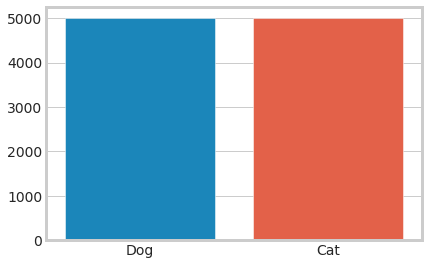

In [139]:
sns.set_style('whitegrid')
sns.barplot(x=['Dog', 'Cat'],
            y=[len(images_dog),
               len(images_cat)])

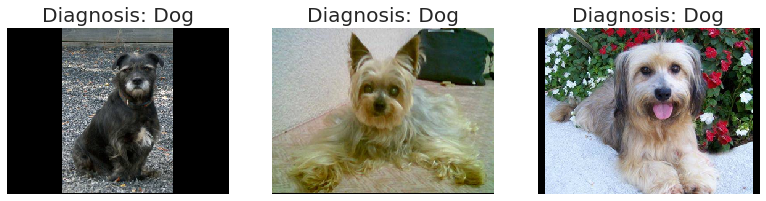

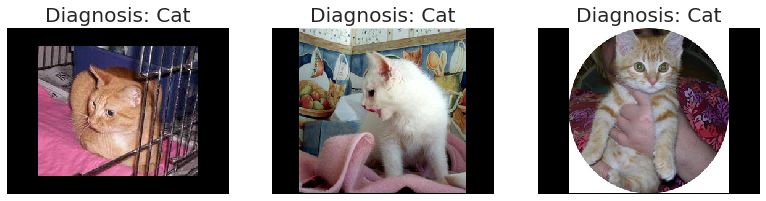

In [140]:
def get_image(path):
#   return cv2.imread(path, 0)
    return cv2.imread(path)

def get_resized_image(path, width, height):
  im = Image.fromarray(get_image(path))
  im_w, im_h = im.size

  # Proportionally scale to be contained within canvas bounds.
  if im_w > width:
    im_h = int(width/im_w * im_h)
    im_w = width
  if im_h > height:
    im_w = int(height/im_h * im_w)
    im_h = height

  if [im_w, im_h] != list(im.size):
    im.thumbnail((im_w, im_h), Image.ANTIALIAS)

  # Return the image over a black background.    
  im_resized = Image.new('RGB', (width, height), (0, 0, 0))
  offset = ((width - im.size[0]) // 2,
            (height - im.size[1]) // 2)
  im_resized.paste(im, offset)

  return np.array(im_resized)

def plot_sample_images(image_set, image_label,
                      width=WIDTH//2, height=HEIGHT//2,
                      rows=1, cols=3,
                      size_w=4, size_h=3):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  for idx in range(rows*cols):
    i = random.randint(0, len(image_set))
#     im = get_resized_image(image_set[i], WIDTH, HEIGHT)[:, :, 0]
#     ax[idx%cols].imshow(im, cmap="bone")
    im = get_resized_image(image_set[i], WIDTH, HEIGHT)
#     print(im.shape)
    ax[idx%cols].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax[idx%cols].axis('off')
    ax[idx%cols].set_title('Diagnosis: {}'.format(image_label))
  plt.show()

plot_sample_images(images_dog, 'Dog')
plot_sample_images(images_cat, 'Cat')

In [0]:
def VGG16_bw():
    model = VGG16(weights='imagenet', include_top=False)
    block1_conv1 = model.get_layer('block1_conv1').get_weights()
    weights, biases = block1_conv1

    weights = np.transpose(weights, (3, 2, 0, 1))
    kernel_out_channels, kernel_in_channels, kernel_rows, kernel_columns = weights.shape
    grayscale_weights = np.zeros((kernel_out_channels, 1, kernel_rows, kernel_columns))

    for i in range(kernel_out_channels):
        get_kernel = weights[i, :, :, :]
        temp_kernel = np.zeros((3, 3))
        in_channels, in_rows, in_columns = get_kernel.shape

        for in_row in range(in_rows):
            for in_col in range(in_columns):
                feature_red = get_kernel[0, in_row, in_col]
                feature_green = get_kernel[1, in_row, in_col]
                feature_blue = get_kernel[2, in_row, in_col]

                total = (feature_red * 0.2989) + (feature_green * 0.5870) + (feature_blue * 0.1140)
                temp_kernel[in_row, in_col] = total

        temp_kernel = np.expand_dims(temp_kernel, axis=0)
        grayscale_weights[i, :, :, :] = temp_kernel

    grayscale_weights = np.transpose(grayscale_weights, (2, 3, 1, 0))
    new_block1_conv1 = [grayscale_weights, biases]
    vgg16_weights = {}
    for layer in model.layers[2:]:
        if "conv" in layer.name:
            vgg16_weights["vgg16bw_" + layer.name] = model.get_layer(layer.name).get_weights()

    del model

    # Custom build VGG16

    vgg16_bw_input = Input(shape=(HEIGHT, WIDTH, 1), name='vgg16bw_input')
    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(HEIGHT, WIDTH, 1), data_format="channels_last", name='vgg16bw_block1_conv1')(vgg16_bw_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='vgg16bw_block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='vgg16bw_block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='vgg16bw_block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='vgg16bw_block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='vgg16bw_block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='vgg16bw_block5_conv3')(x)
    x = MaxPooling2D((8, 8), strides=(8, 8), name='vgg16bw_block5_pool')(x)

    vgg16_bw = Model(inputs=vgg16_bw_input, outputs=x)

    vgg16_bw.get_layer('vgg16bw_block1_conv1').set_weights(new_block1_conv1)
    for layer in vgg16_bw.layers[2:]:
        if 'conv' in layer.name:
            vgg16_bw.get_layer(layer.name).set_weights(vgg16_weights[layer.name])

    return vgg16_bw

In [0]:
def pay_attention(m_input, name):
  # Based on https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age#Attention-Model
  pt_depth = 512
  bn_features = BatchNormalization()(m_input)

  attn = Conv2D(64, kernel_size=(1,1), padding='same', activation='relu')(bn_features)
  attn = Conv2D(16, kernel_size=(1,1), padding='same', activation='relu')(attn)
  attn = Conv2D(1, 
                kernel_size=(1,1), 
                padding='valid', 
                activation='sigmoid',
                name=name)(attn)
  up_c2_w = np.ones((1, 1, 1, pt_depth))
  up_c2 = Conv2D(pt_depth,
                 kernel_size=(1,1),
                 padding='same', 
                 activation='linear',
                 use_bias=False,
                 weights=[up_c2_w])
  up_c2.trainable = False
  attn = up_c2(attn)

  mask_features = multiply([attn, bn_features])
  gap_features = GlobalAveragePooling2D()(mask_features)
  gap_mask = GlobalAveragePooling2D()(attn)
  attn_gap = Lambda(lambda x: x[0]/x[1])([gap_features, gap_mask])

  return attn_gap

In [0]:
def build_model(optimizer):
  common_input = Input(shape=(HEIGHT, WIDTH, 3))
  base_model_1 = VGG16_bw()
  base_model_2 = VGG19(weights='imagenet',
                       include_top=False,
                       input_shape=(HEIGHT, WIDTH, 3))

  r = Lambda(lambda x: x[:, :, :, 1])(common_input)
  r = Reshape(target_shape=(HEIGHT, WIDTH, 1))(r)
  x1 = base_model_1(r)
  a1 = pay_attention(x1, 'attn_1')
  x1 = Dense(1024, activation='relu')(a1)
  x1 = Dropout(0.5)(x1)
  x1 = Dense(512, activation='relu')(a1)
  x1 = Dropout(0.5)(x1)

  x2 = base_model_2(common_input)
  a2 = pay_attention(x2, 'attn_2')
  x2 = Dense(1024, activation='relu')(a2)
  x2 = Dropout(0.5)(x2)
  x2 = Dense(512, activation='relu')(a2)
  x2 = Dropout(0.5)(x2)

  c = concatenate([x1, x2])
  p = Dense(len(class_w), activation='softmax')(c)

  for layer in base_model_1.layers:
    layer.trainable = False

  for layer in base_model_2.layers:
    layer.trainable = False
    layer._name = layer.name + '_2'

  model = Model(inputs=common_input, outputs=p)
  model.compile(optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [163]:
model = build_model(Adam(learning_rate=LEARNING_RATE))
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 270, 360, 3) 0                                            
__________________________________________________________________________________________________
lambda_6 (Lambda)               (None, 270, 360)     0           input_7[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 270, 360, 1)  0           lambda_6[0][0]                   
__________________________________________________________________________________________________
model_4 (Model)                 (None, 2, 2, 512)    14713536    reshape_2[0][0]                  
____________________________________________________________________________________________

In [0]:
checkpoint = ModelCheckpoint("./models/animal_classifier-{epoch:0.2f}-{val_loss:.3f}",
                             monitor='val_acc', 
                             save_weights_only=True,
                             save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              patience=3,
                              cooldown=2,
                              min_lr=1e-12,
                              verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',
                               mode='max',
                               patience=2,
                               verbose=1,
                               restore_best_weights=True)
callbacks = [checkpoint, reduce_lr, early_stopping]

Epoch 1/5
500/500 [==============================] - 306s 611ms/step - loss: 0.2890 - acc: 0.8643 - val_loss: 0.1279 - val_acc: 0.9505
Epoch 2/5
500/500 [==============================] - 297s 594ms/step - loss: 0.1475 - acc: 0.9388 - val_loss: 0.1101 - val_acc: 0.9595
Epoch 3/5
500/500 [==============================] - 296s 593ms/step - loss: 0.1276 - acc: 0.9466 - val_loss: 0.1092 - val_acc: 0.9545
Epoch 4/5
500/500 [==============================] - 295s 589ms/step - loss: 0.1166 - acc: 0.9541 - val_loss: 0.1073 - val_acc: 0.9590
Epoch 5/5
500/500 [==============================] - 294s 588ms/step - loss: 0.1044 - acc: 0.9556 - val_loss: 0.1021 - val_acc: 0.9610


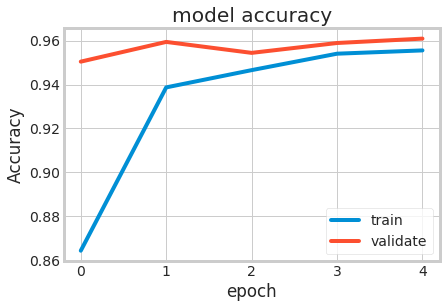

In [164]:
def train_model():
  hist = model.fit_generator(train_generator,
                             steps_per_epoch=len(train_generator),
                             epochs=5,
                             verbose=1,
                             callbacks=callbacks,
                             validation_data=test_generator,
                             validation_steps=len(test_generator),
                             class_weight=class_w)

  plt.plot(hist.history['acc'])
  plt.plot(hist.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validate'], loc='best')
  plt.show()

train_model()

In [0]:
if KEEP_TRAINING:
  # Improving Generalization Performance by Switching from Adam to SGD
  # https://arxiv.org/abs/1712.07628
  model.compile(SGD(learning_rate=1e-5, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  train_model()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


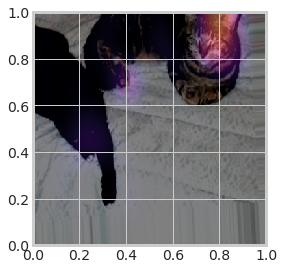



Real: Cat

Predict: Cat


In [158]:
Val = 15

im_to_show = test_generator[0][0][Val]
# plt.imshow(test_generator[0][0][0])
attn_func_1 = k.function(inputs = [model.get_input_at(0), k.learning_phase()],
  outputs = [attn_1.get_output_at(0)]
)

attn_func_2 = k.function(inputs = [model.get_input_at(0), k.learning_phase()],
  outputs = [attn_2.get_output_at(0)]
)
attn_img_1 = attn_func_1(np.array([im_to_show]))[0]
attn_img_2 = attn_func_2(np.array([im_to_show]))[0]
attn_img = (attn_img_1 + attn_img_2) / 2
attn_img = attn_img[0, :, :, 0]
extent = 0, 1, 0, 1
plt.imshow(im_to_show, cmap='gray_r', extent=extent)
plt.imshow(attn_img, cmap='magma', vmin=0, vmax=1,
                              extent=extent, alpha=0.5,
                              interpolation='lanczos')

plt.show()

classified = ["Cat", "Dog"]
print(f"\n\nReal: {classified[test_generator.classes[Val]]}")
print(f"\nPredict: {classified[np.argmax(model.predict(test_generator[0][0][Val].reshape(1, 270, 360, 3)))]}")

In [165]:
vl_score = model.predict_generator(test_generator)

classes = ['Cats', 'Dogs']
print(classification_report(test_generator.classes,
                            np.argmax(vl_score, axis=1),
                            target_names=classes))
print('AUC: ', roc_auc_score(test_generator.classes,
                             np.argmax(vl_score, axis=1)))

              precision    recall  f1-score   support

        Cats       0.49      0.50      0.50      1000
        Dogs       0.49      0.49      0.49      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000

AUC:  0.49349999999999994


In [0]:
acc = accuracy_score(test_generator.classes, np.argmax(vl_score, axis=1))*100.0
cm = confusion_matrix(test_generator.classes, np.argmax(vl_score, axis=1))
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(12,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Animal Classificaion Accuracy: {0:.1f}%'.format(acc))
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [0]:
for l in range(len(model.layers)):
  if model.layers[l].name == 'attn_1':
    attn_1 = model.layers[l + 1]
  elif model.layers[l].name == 'attn_2':
    attn_2 = model.layers[l]

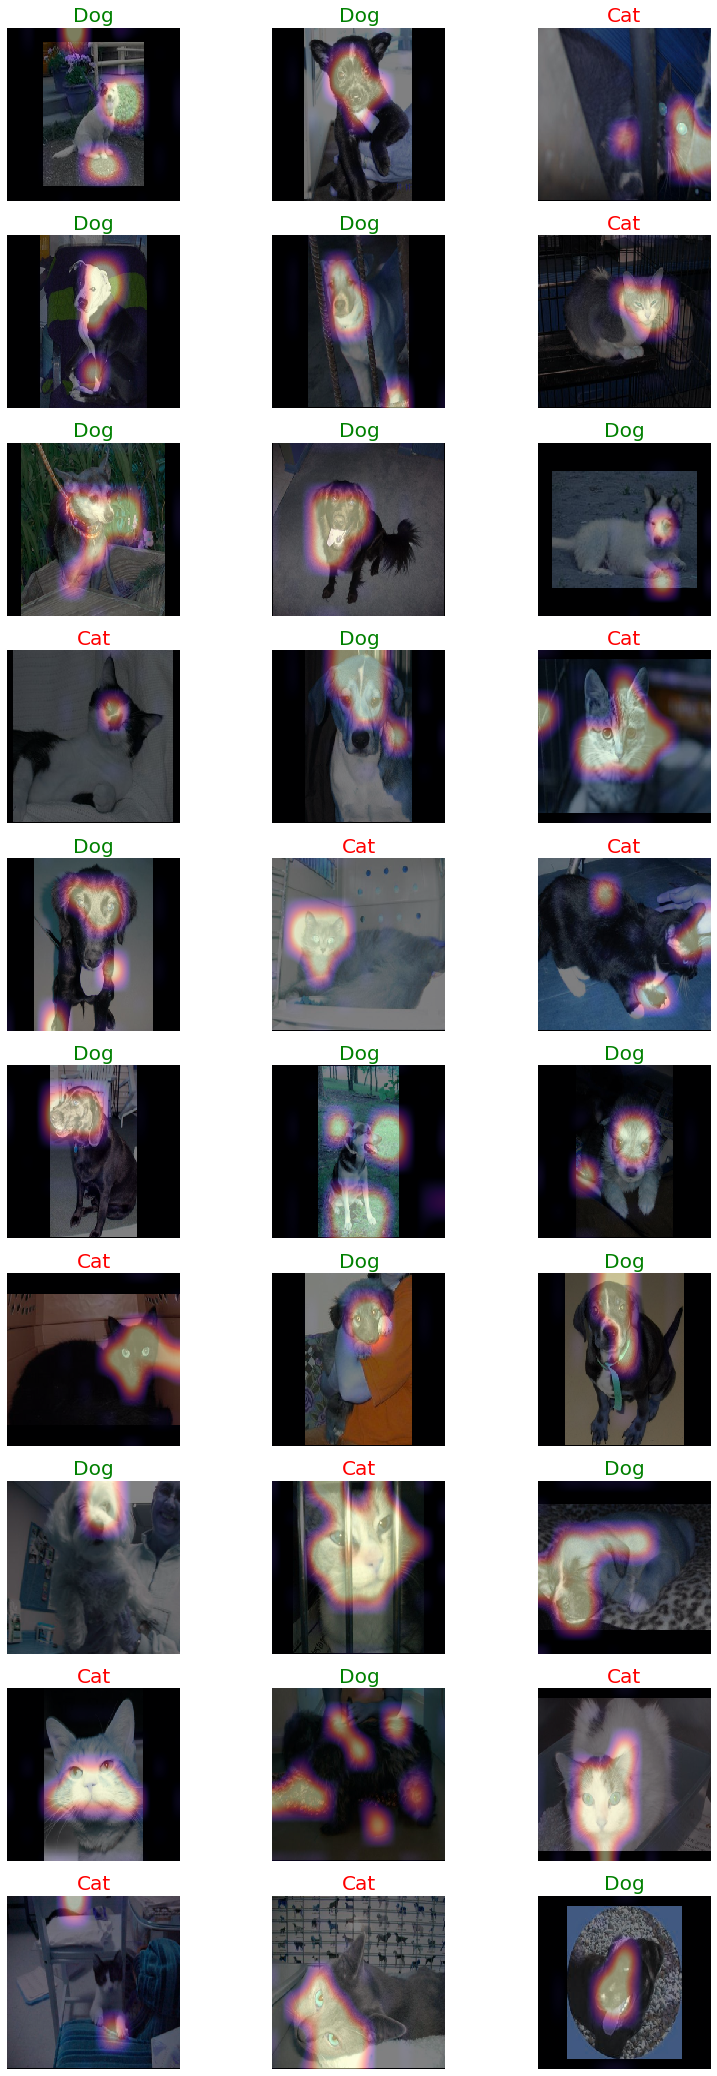

In [171]:
def plot_val_imgs(width=WIDTH//2, height=HEIGHT//2,
                   rows=10, cols=3,
                   size_w=4, size_h=3.5):
  f,ax = plt.subplots(rows, cols, figsize=(cols*size_w, rows*size_h))

  label_CM = {
    0: 'red',  # Cat
    1: 'green' # Dog
  }

  X_test_images, y_test_images = test_generator.next()

  attn_func_1 = k.function(inputs = [model.get_input_at(0), k.learning_phase()],
    outputs = [attn_1.get_output_at(0)]
  )

  attn_func_2 = k.function(inputs = [model.get_input_at(0), k.learning_phase()],
    outputs = [attn_2.get_output_at(0)]
  )

  for idx in range(0, rows*cols):
    i = random.randint(0, len(images_test))
    pred = np.round(vl_score[i][1])
    score = 1 if test_generator.classes[i] == 1 else 0
    im_data = get_resized_image(images_test[i], 300, 225)

    # im_data_xray = xray_process(im_data)
    attn_img_1 = attn_func_1(np.array([im_data]))[0]
    attn_img_2 = attn_func_2(np.array([im_data]))[0]
    attn_img = (attn_img_1 + attn_img_2) / 2
    attn_img = attn_img[0, :, :, 0]
        
    diagnosis_type = 'Dog' if test_generator.classes[i] == 1 else 'Cat'
    diagnosis = '{}'.format(diagnosis_type)

    extent = 0, 1, 0, 1

    ax[idx//cols,idx%cols].imshow(im_data, cmap='gray_r', extent=extent)
    ax[idx//cols,idx%cols].imshow(attn_img, cmap='magma', vmin=0, vmax=1,
                                  extent=extent, alpha=0.5,
                                  interpolation='lanczos')
    ax[idx//cols,idx%cols].axis('off')
    ax[idx//cols,idx%cols].set_title(diagnosis, color=label_CM[score])
  plt.show()

plot_val_imgs()